## COVID19 Forecasting Project

**ECE 685:** Deep Learning <br>
**Student:** Guillem Amat, Sebastián Soriano Pérez

### Setup

#### Loading Packages

In [33]:
'''Loading packages and additional setup'''
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pdb
import csv
import os
import warnings
from countrygroups import EUROPEAN_UNION
from us import states
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams

# Hides warnings
warnings.filterwarnings("ignore")

# Increases resolution of Jupyter Notebooks on Macs
%config InlineBackend.figure_format = 'retina'

In [2]:
'''Loading PyTorch and specific functions'''
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

<br>

#### Loading Data

In [18]:
'''Loading COVID cases and fatalities data'''
#%cd Desktop
#PATH = r'C:\Users\guill\Desktop\Final Project'
#os.chdir(PATH)
#data = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'week_5', 'train.csv'))
data = pd.read_csv('../Data/week_5/train.csv')

<br>

**Data preprocessing**

In [19]:
'''Creating "location" column'''
data['County']         = data['County'].fillna('')
data['Province_State'] = data['Province_State'].fillna('')

data['location'] = data['Country_Region'] + ' ' + data['Province_State'] + ' ' + data['County']
data.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue,location
0,1,,,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0,Afghanistan
1,2,,,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0,Afghanistan
2,3,,,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0,Afghanistan
3,4,,,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0,Afghanistan
4,5,,,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0,Afghanistan


In [20]:
'''Creating "population" dataset'''
population = data[['location', 'Population']].drop_duplicates()
population.head()

,location,Population
0,Afghanistan,27657145
280,Albania,2886026
560,Algeria,40400000
840,Andorra,78014
1120,Angola,25868000


In [26]:
'''Loading geographical coordinates for every country'''
#coordinates = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'other', 'coordinates.csv'))
coordinates = pd.read_csv('../Data/other/coordinates.csv')
coordinates.head()

,Location,Longitude,Latitude
0,Afghanistan,66.238514,33.768006
1,Albania,19.999962,41.000028
2,Algeria,2.999983,28.000027
3,Andorra,1.573203,42.540717
4,Angola,17.569124,-11.877577


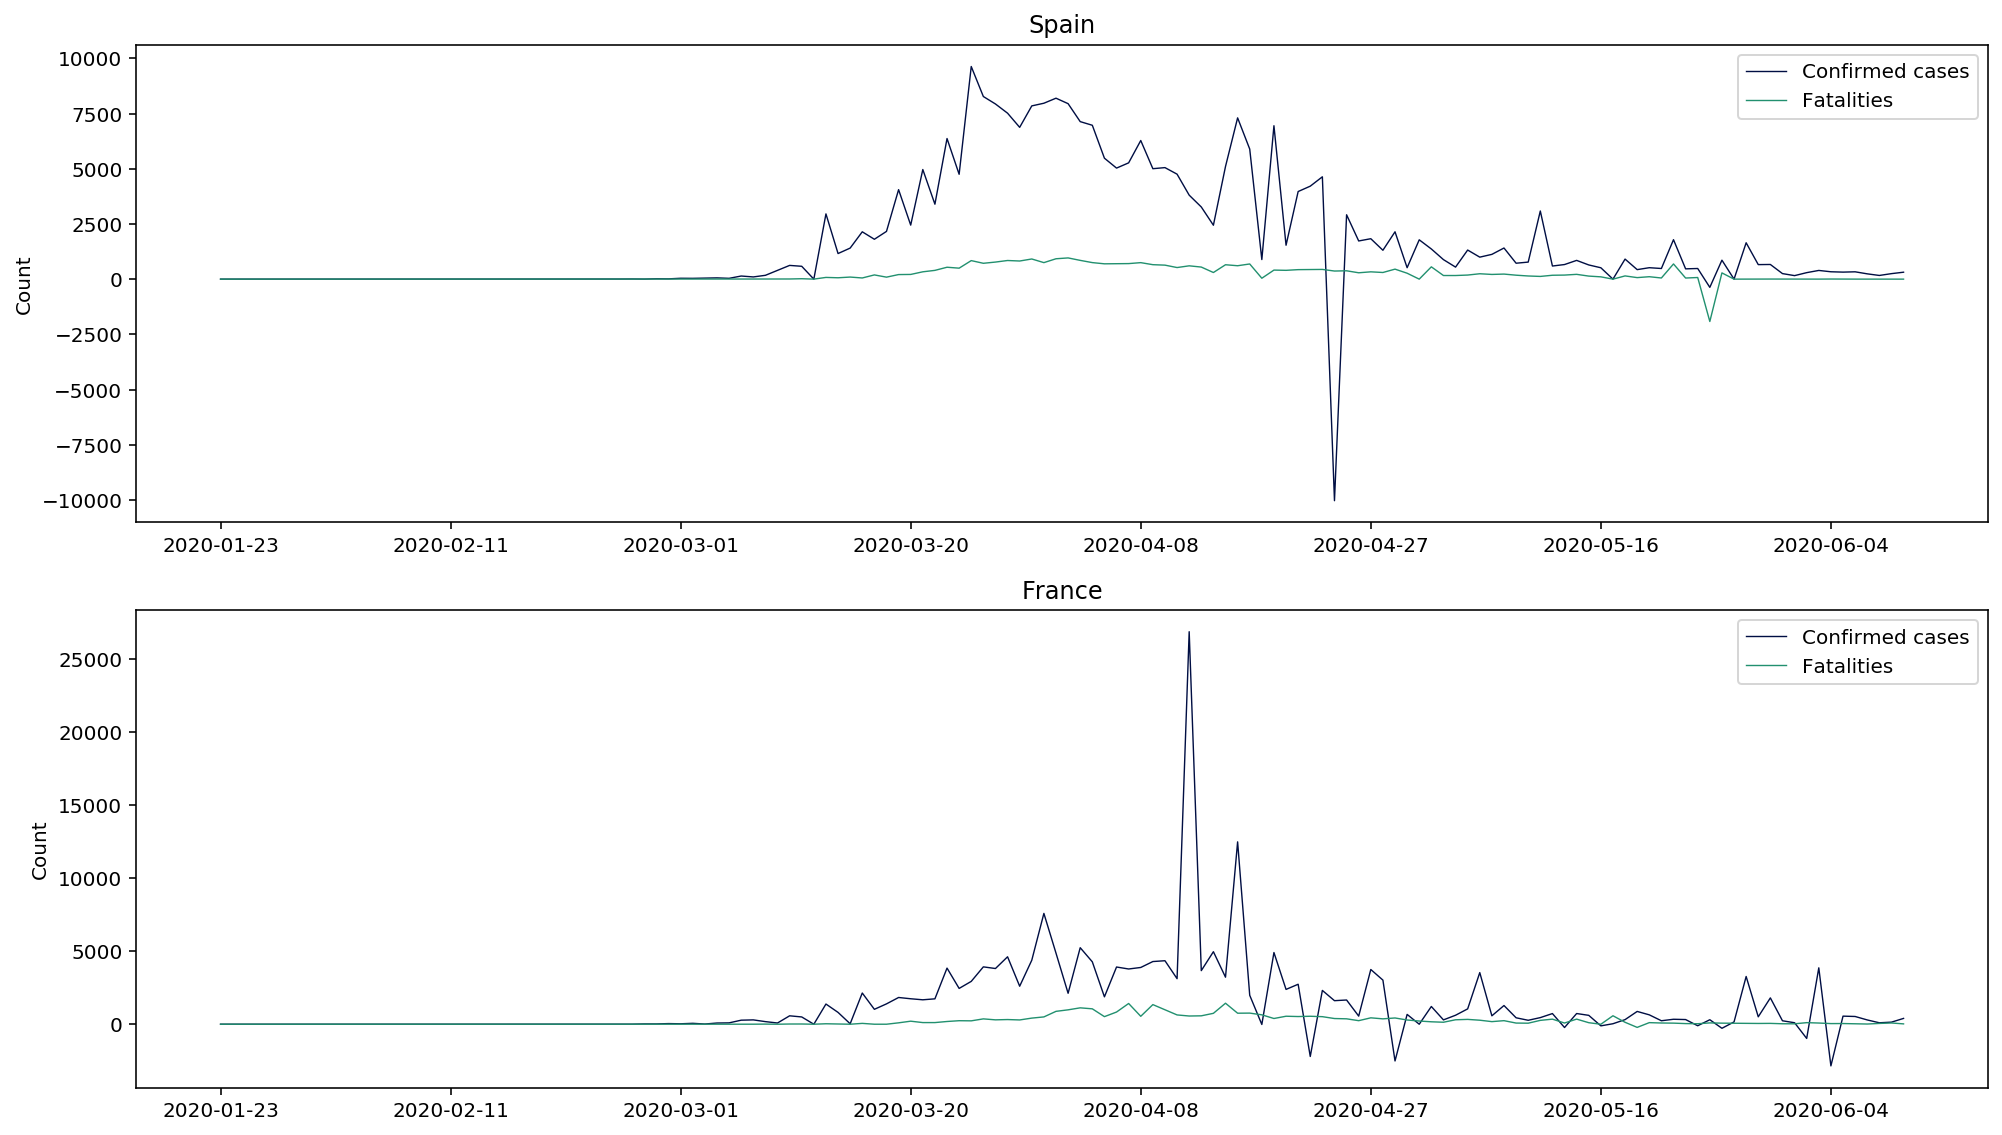

In [67]:
'''Plotting sample countries'''
rcParams['figure.figsize'] = 14, 8
plt.figure()

plt.subplot(2, 1, 1)

plt.title('Spain')
#plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(
    data[(data['location'] == 'Spain  ') & (data['Target'] == 'ConfirmedCases')]['Date'], 
    data[(data['location'] == 'Spain  ') & (data['Target'] == 'ConfirmedCases')]['TargetValue'], 
    color='#000E43', linewidth=0.7, label='Confirmed cases'
)
plt.plot(
    data[(data['location'] == 'Spain  ') & (data['Target'] == 'Fatalities')]['Date'], 
    data[(data['location'] == 'Spain  ') & (data['Target'] == 'Fatalities')]['TargetValue'], 
    color='#22906F', linewidth=0.7, label='Fatalities'
)
plt.xticks(range(0, 141, 19), rotation=0)
plt.legend()
plt.tight_layout()

plt.subplot(2, 1, 2)

plt.title('France')
#plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(
    data[(data['location'] == 'France  ') & (data['Target'] == 'ConfirmedCases')]['Date'], 
    data[(data['location'] == 'France  ') & (data['Target'] == 'ConfirmedCases')]['TargetValue'], 
    color='#000E43', linewidth=0.7, label='Confirmed cases'
)
plt.plot(
    data[(data['location'] == 'France  ') & (data['Target'] == 'Fatalities')]['Date'], 
    data[(data['location'] == 'France  ') & (data['Target'] == 'Fatalities')]['TargetValue'], 
    color='#22906F', linewidth=0.7, label='Fatalities'
)
plt.xticks(range(0, 141, 19), rotation=0)
plt.legend()
plt.tight_layout()

<br>

**Creating global dataset**

In [200]:
'''Creating a global aggregated dataset'''
data_global = pd.pivot_table(
    data, index=['Date'], columns='Target', values='TargetValue', aggfunc=np.sum
).reset_index()
data_global = data_global.drop(['Date'], axis=1)
data_global.head()

Target,ConfirmedCases,Fatalities
0,194,2
1,564,16
2,979,32
3,1358,28
4,1612,52


In [201]:
'''Rescaling variables'''
scaler = MinMaxScaler()
scaler = scaler.fit(data_global)
result = scaler.transform(data_global)

# How to transform data back to their original values
result_inv = scaler.inverse_transform(result)

In [202]:
'''Creating NumPy array'''
dataset = result
train   = dataset[:95, :]
test    = dataset[95:, :]
dataset.shape, train.shape, test.shape

((140, 2), (95, 2), (45, 2))

In [203]:
def create_sequences(data, seq_length):
    '''Function to create sequences from time series data'''
    xs = []; ys = []
    
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    
    #pdb.set_trace()
    return np.array(xs), np.array(ys)

In [204]:
'''Creating sequences'''
seq_length = 25
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test   = create_sequences(test, seq_length)

In [205]:
'''Creating PyTorch tensors'''
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_test, y_test   = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

<br>

### Modeling

**Setup**

In [130]:
'''Additional setup for models'''
torch.set_default_tensor_type(torch.FloatTensor)

def path_model(model):
    '''Function to create paths for models'''
    #PATH1 = os.path.join(os.getcwd(), 'Models', f'{model}_model')
    PATH1 = f'../Models/{model}_model'
    #PATH2 = os.path.join(os.getcwd(), 'Models', f'{model}_state_dictionary')
    PATH2 = f'../Models/{model}_state_dictionary'
    return PATH1, PATH2

In [247]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, epochs=50, net=None):
    '''Function to train a model'''
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)
    
    train_loss = np.zeros(epochs)
    test_loss  = np.zeros(epochs)
    
    values_test  = []
    values_train = [] 
    
    #pdb.set_trace()
    
    for t in range(epochs):
        if (net != 'CNN') and (net != 'ANN'): model.reset_hidden_state()
        optimizer.zero_grad()
        
        y_pred = model(train_data)
        loss   = loss_fn(y_pred.float(), train_labels[:, :2])
        
        values_train.append(y_pred.detach().numpy()) 
        train_loss[t] = loss.item()
        
        loss.backward()
        optimizer.step()
        
        #pdb.set_trace()
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(test_data)
                loss_2 = loss_fn(y_test_pred.float(), test_labels[:, :2])
            test_loss[t] = loss_2.item()
            values_test.append(y_test_pred.detach().numpy())  
            
            if t == 0:
                string = f'|Epoch: {t} | Train Loss: {round(train_loss[t].item(), 2)} | Test Loss: {round(test_loss[t].item(), 2)}|'
                print('-'*len(string)); print(string); print('-'*len(string))
                
            elif t % 50 == 0:
                string = f'|Epoch: {t} | Train Loss: {round(train_loss[t].item(), 2)} | Test Loss: {round(test_loss[t].item(), 2)}|'
                print(string); print('-'*len(string))
        
        #pdb.set_trace()   
        
    return model.eval(), train_loss, test_loss, values_test, values_train

<br>

#### Artificial Neural Network

In [266]:
class ANN(nn.Module):
    '''ANN model'''
    def __init__(self, in_features, net_width, n_hidden, out_features):
        super().__init__()
        
        #Input Layer
        self.initial = torch.nn.Linear(in_features=in_features, out_features=net_width, bias=True)
        
        #Flexible number of Layers
        self.layers = torch.nn.ModuleList([])
        self.layers.extend([torch.nn.Linear(in_features=net_width, out_features=net_width) for n in range(n_hidden)])
        
        #Output Layer
        self.output = torch.nn.Linear(net_width, out_features)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = torch.relu(self.initial(x))
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            x = torch.relu(x)
        
        x = self.output(x)
        
        return x 

In [267]:
'''Training model'''
ann = ANN(in_features=(25 * 2), net_width=500, n_hidden=10, out_features=2)
ann, train_loss, test_loss, values_test, values_train = train_model(ann, X_train, y_train, X_test, y_test, epochs=1000, net='CNN')

-------------------------------------------------
|Epoch: 0 | Train Loss: 24.13 | Test Loss: 12.92|
-------------------------------------------------
|Epoch: 50 | Train Loss: 1.46 | Test Loss: 1.37|
------------------------------------------------
|Epoch: 100 | Train Loss: 0.42 | Test Loss: 1.28|
-------------------------------------------------
|Epoch: 150 | Train Loss: 0.27 | Test Loss: 1.23|
-------------------------------------------------
|Epoch: 200 | Train Loss: 0.19 | Test Loss: 1.1|
------------------------------------------------
|Epoch: 250 | Train Loss: 0.14 | Test Loss: 1.05|
-------------------------------------------------
|Epoch: 300 | Train Loss: 0.11 | Test Loss: 1.23|
-------------------------------------------------
|Epoch: 350 | Train Loss: 0.1 | Test Loss: 1.23|
------------------------------------------------
|Epoch: 400 | Train Loss: 0.1 | Test Loss: 1.53|
------------------------------------------------
|Epoch: 450 | Train Loss: 0.08 | Test Loss: 1.46|
--------

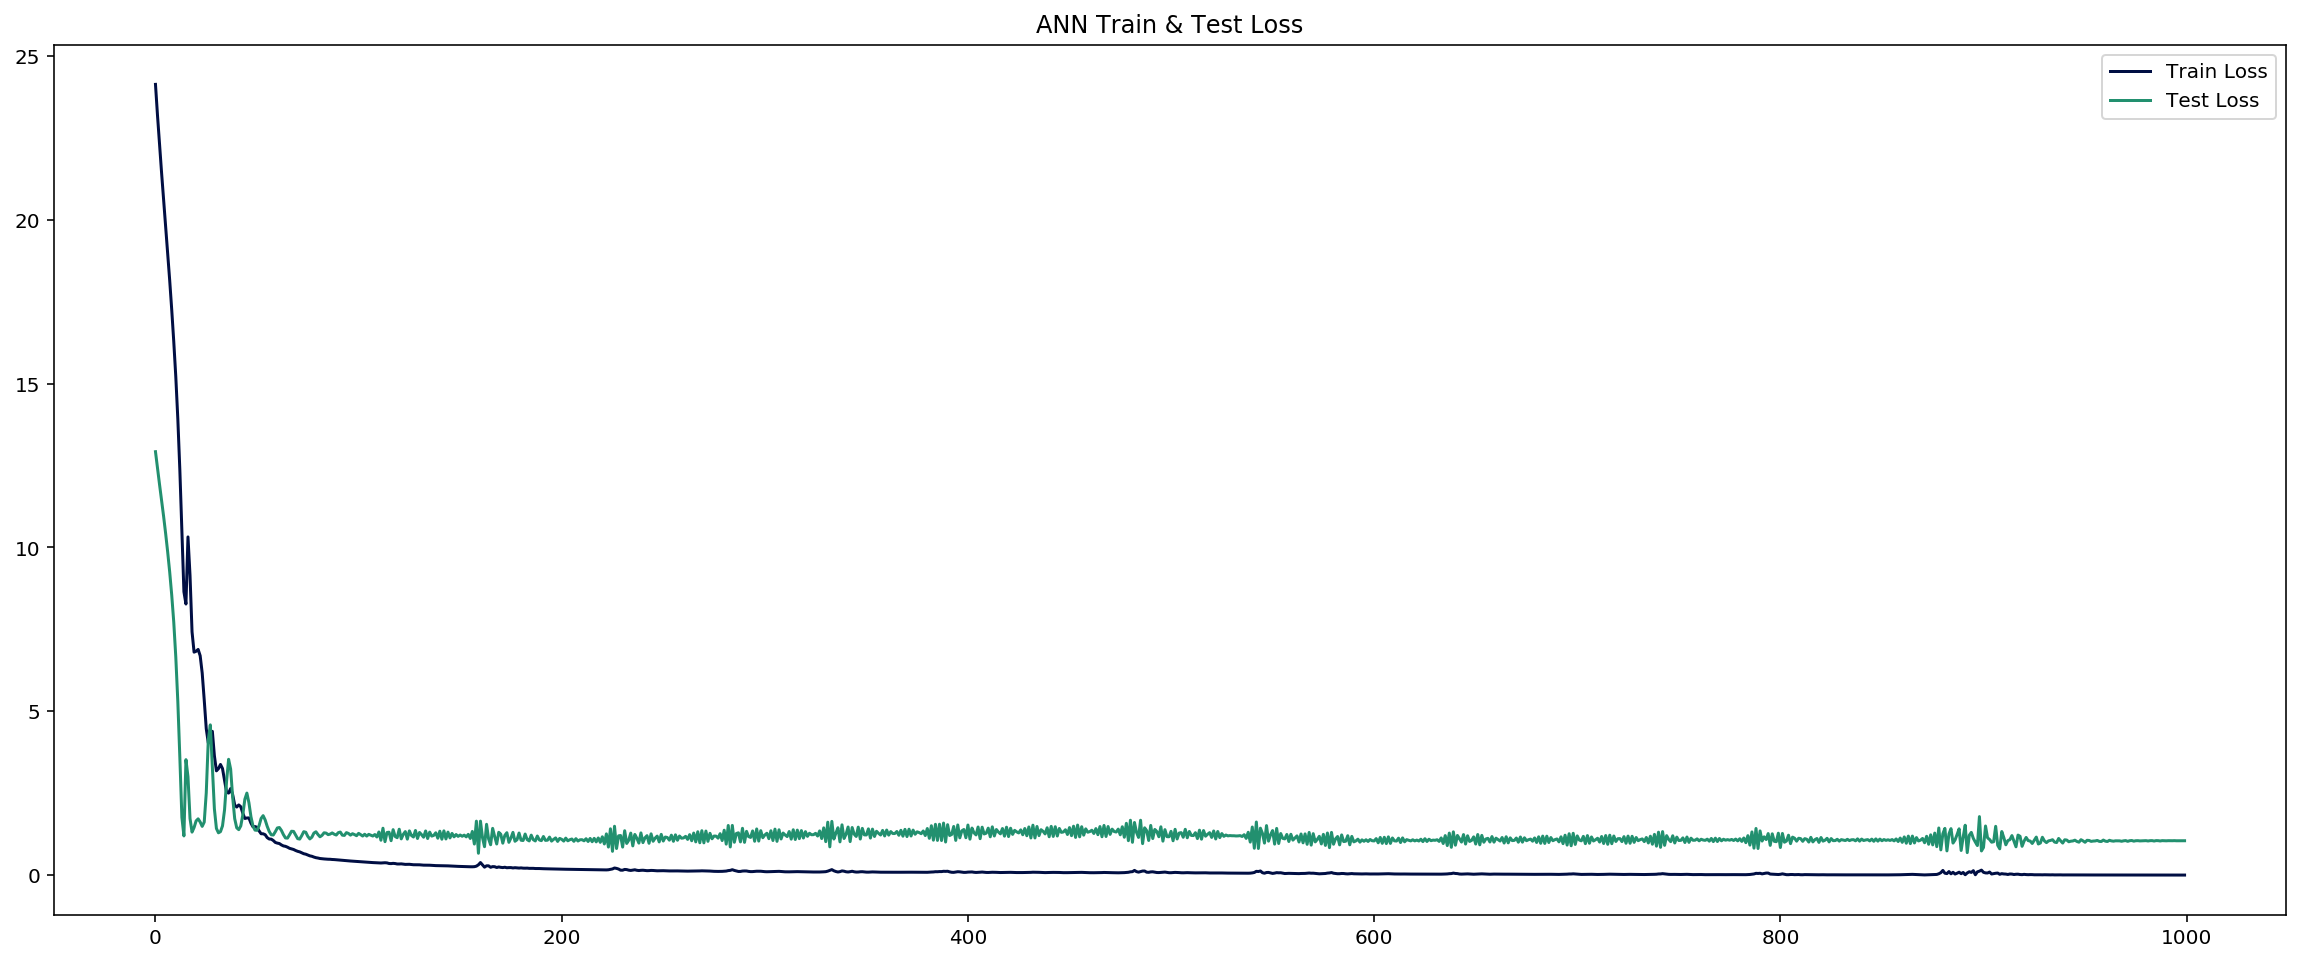

In [268]:
'''Plotting train and test loss'''
plt.figure(figsize=(20, 8))

plt.title('ANN Train & Test Loss')
plt.plot(train_loss, color='#000E43', label = 'Train Loss')
plt.plot(test_loss, color='#22906F', label = 'Test Loss')
plt.legend()

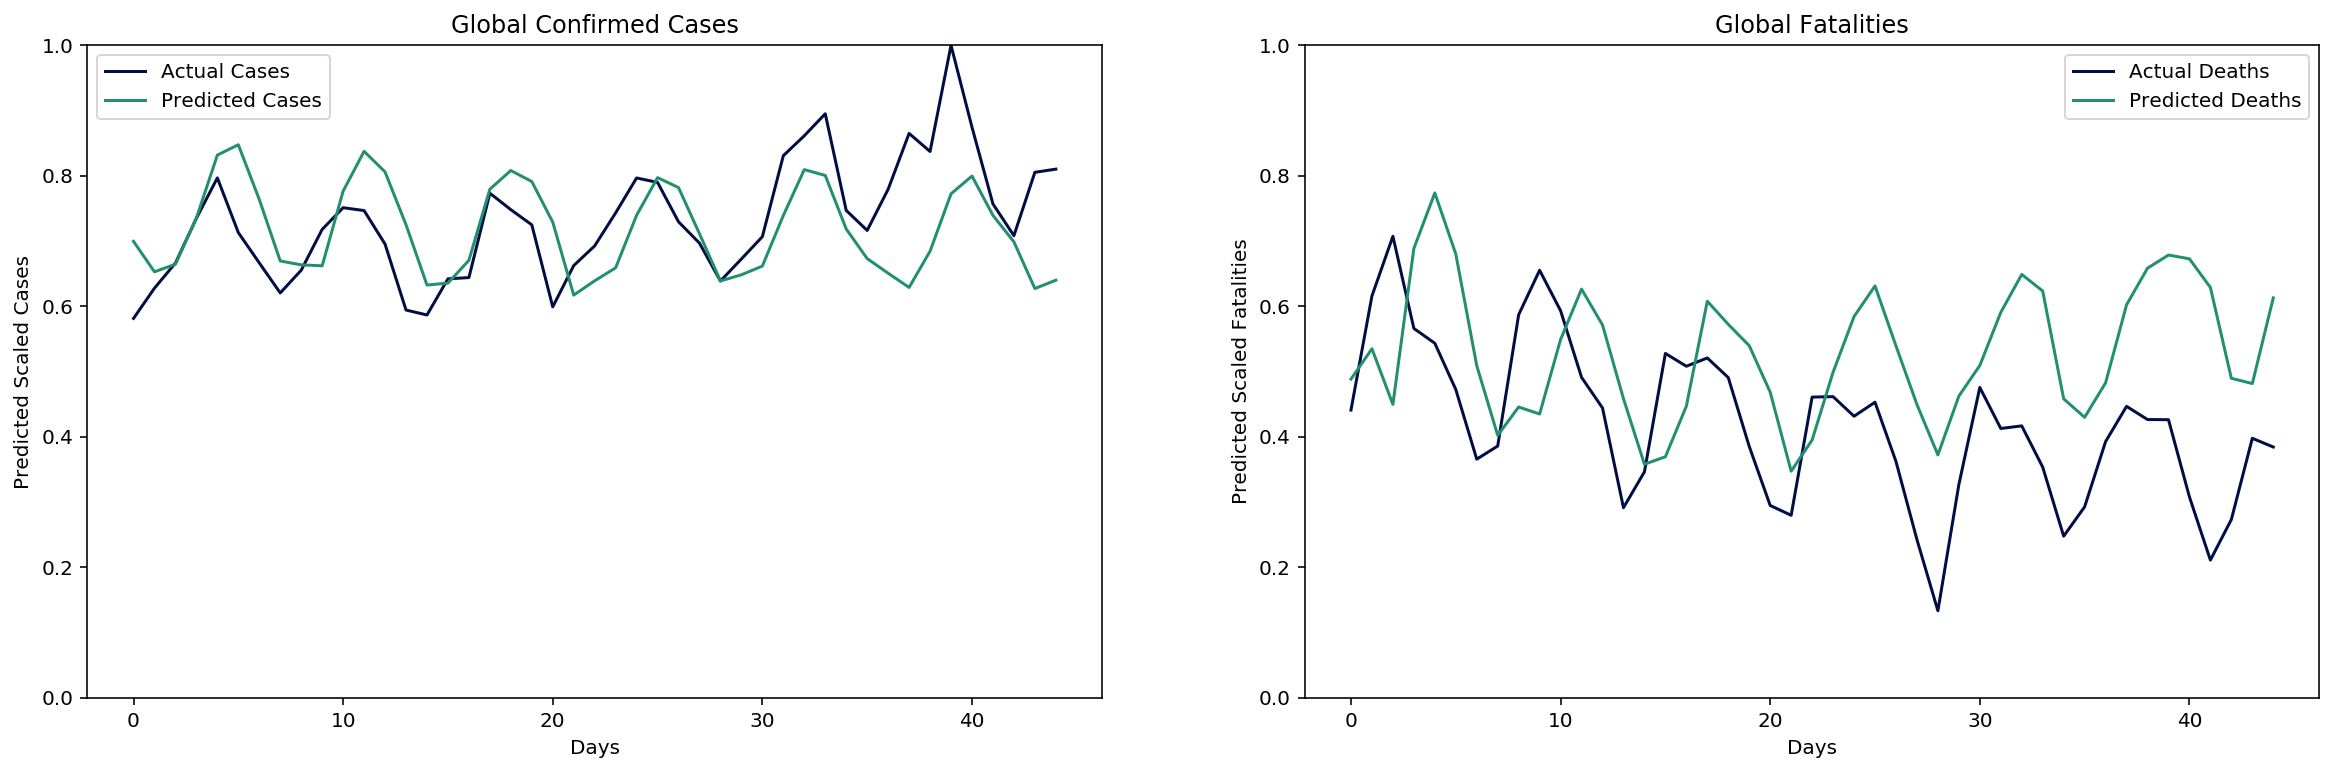

In [269]:
'''Plotting predictions'''
#Actual Values
dset, _ = create_sequences(dataset, seq_length=25)
dset = torch.from_numpy(dset).float()

#Predictions
final = dset[-45:, :]
predictions = ann(final)

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

# Confirmed Cases
axes[0].plot(dataset[-45:, 0], color='#000E43', label = 'Actual Cases')
axes[0].plot(predictions[:, 0].detach().numpy(), color='#22906F', label='Predicted Cases')
axes[0].set_ylim((0, 1))
axes[0].set_title(f'Global Confirmed Cases')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Predicted Scaled Cases')

axes[0].legend()

# Fatalities
axes[1].plot(dataset[-45:, 1], color='#000E43', label = 'Actual Deaths')
axes[1].plot(predictions[:, 1].detach().numpy(), color='#22906F', label='Predicted Deaths')
axes[1].set_ylim((0, 1))
axes[1].set_title(f'Global Fatalities')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Predicted Scaled Fatalities')
axes[1].legend()

<br>

#### Convolutional Neural Network

In [189]:
class CNN(nn.Module):
    '''CNN model'''
    def __init__(self, n_features=5, seq_len=25, n_output=2):
        super().__init__()
        self.n_features = n_features
        self.seq_len    = seq_len
        
        self.conv1d = nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=1, bias=True) #in: 25, out: 25
        self.fc1    = nn.Linear(in_features=64 * seq_len, out_features=50, bias=True)
        self.relu   = nn.ReLU(inplace=True)
        self.fc2    = nn.Linear(in_features=50, out_features=n_output)
        
    def forward(self,x):
        x = x.transpose(1, 2)
        x = self.conv1d(x)
        x = x.view(-1, 64 * self.seq_len)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [213]:
'''Training model'''
cnn = CNN(n_features=2, seq_len=25, n_output=2)
cnn, train_loss, test_loss, values_test, values_train = train_model(cnn, X_train, y_train, X_test, y_test, epochs=1000, net='CNN')

-----------------------------------------------
|Epoch: 0 | Train Loss: 24.1 | Test Loss: 5.05|
-----------------------------------------------
|Epoch: 50 | Train Loss: 0.7 | Test Loss: 1.66|
-----------------------------------------------
|Epoch: 100 | Train Loss: 0.49 | Test Loss: 1.22|
-------------------------------------------------
|Epoch: 150 | Train Loss: 0.38 | Test Loss: 0.93|
-------------------------------------------------
|Epoch: 200 | Train Loss: 0.31 | Test Loss: 0.78|
-------------------------------------------------
|Epoch: 250 | Train Loss: 0.27 | Test Loss: 0.71|
-------------------------------------------------
|Epoch: 300 | Train Loss: 0.25 | Test Loss: 0.69|
-------------------------------------------------
|Epoch: 350 | Train Loss: 0.23 | Test Loss: 0.69|
-------------------------------------------------
|Epoch: 400 | Train Loss: 0.22 | Test Loss: 0.7|
------------------------------------------------
|Epoch: 450 | Train Loss: 0.2 | Test Loss: 0.73|
-------------

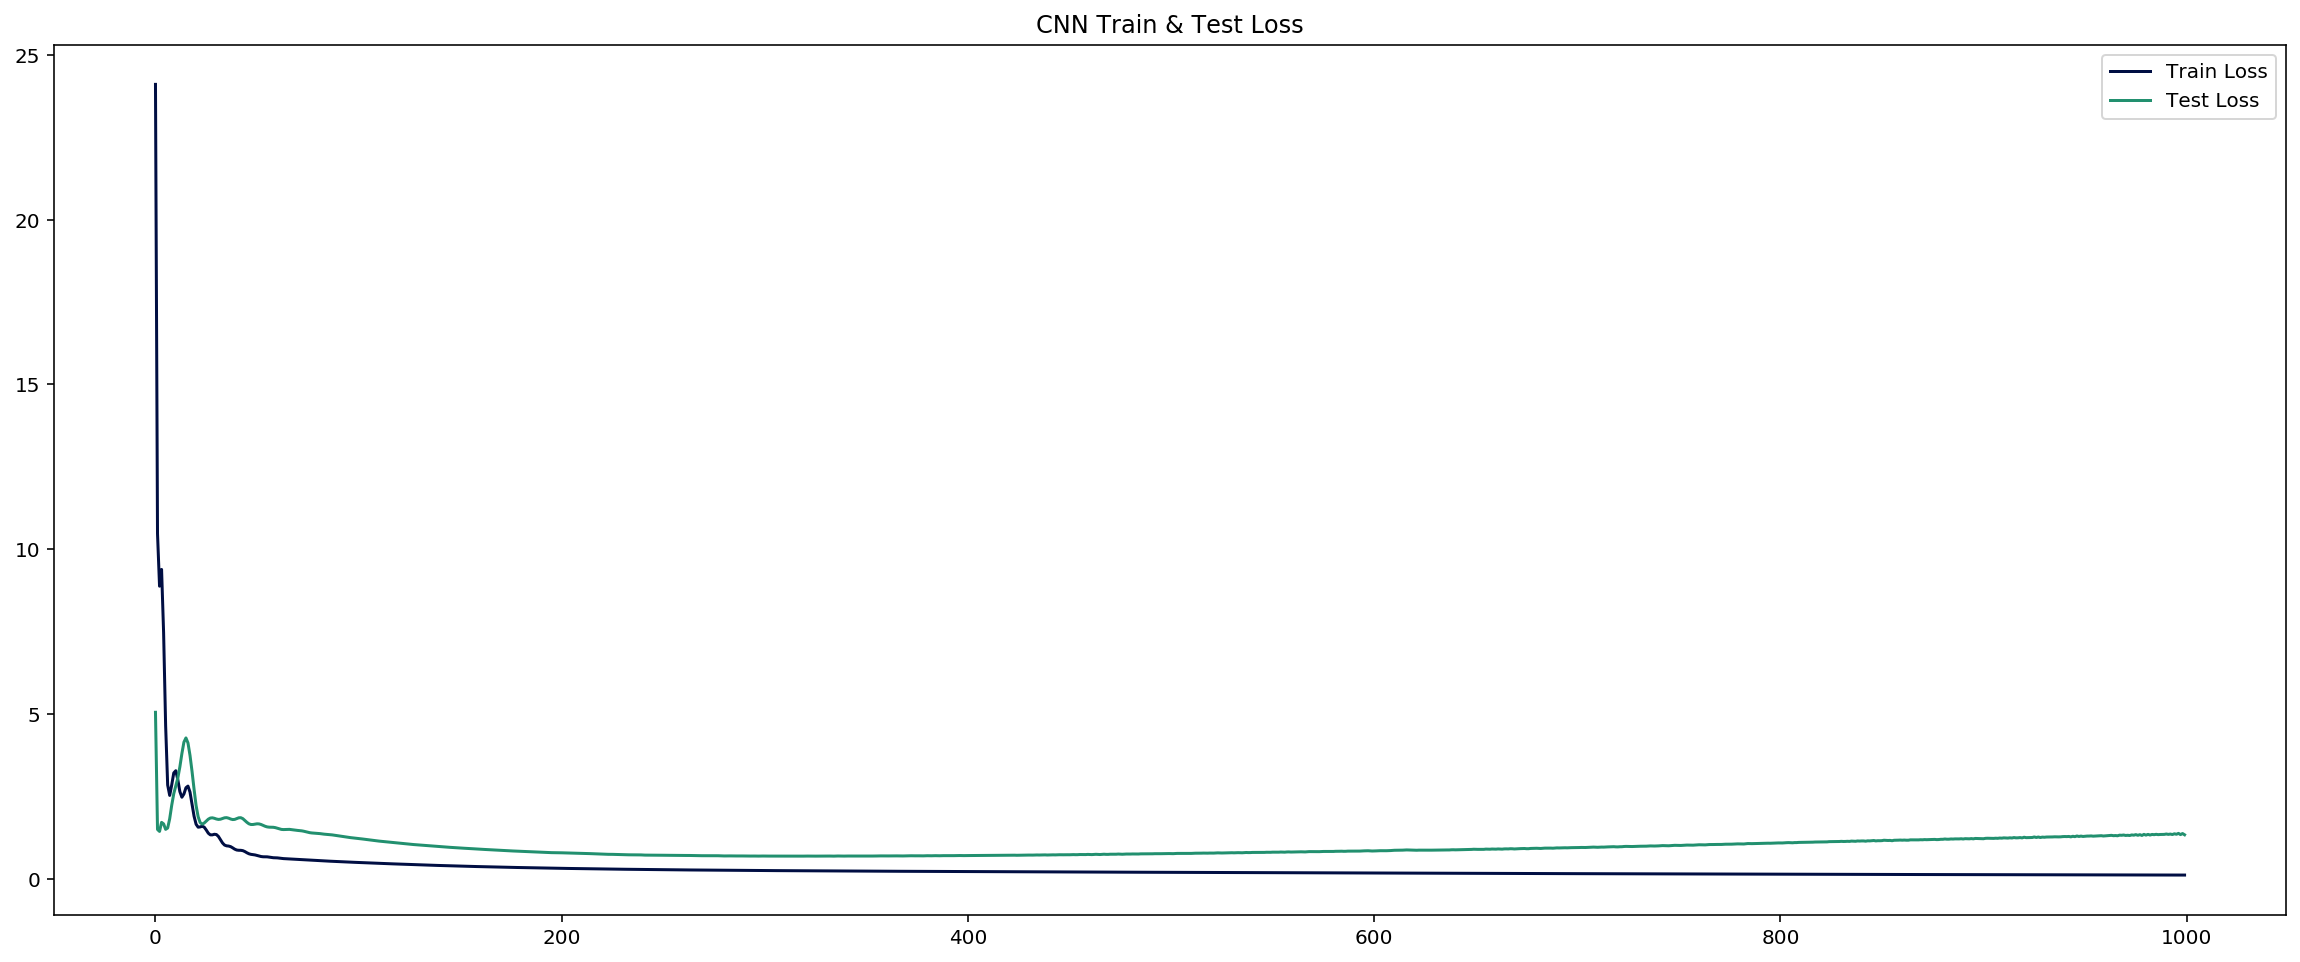

In [214]:
'''Plotting train and test loss'''
plt.figure(figsize=(20, 8))

plt.title('CNN Train & Test Loss')
plt.plot(train_loss, color='#000E43', label = 'Train Loss')
plt.plot(test_loss, color='#22906F', label = 'Test Loss')
plt.legend()

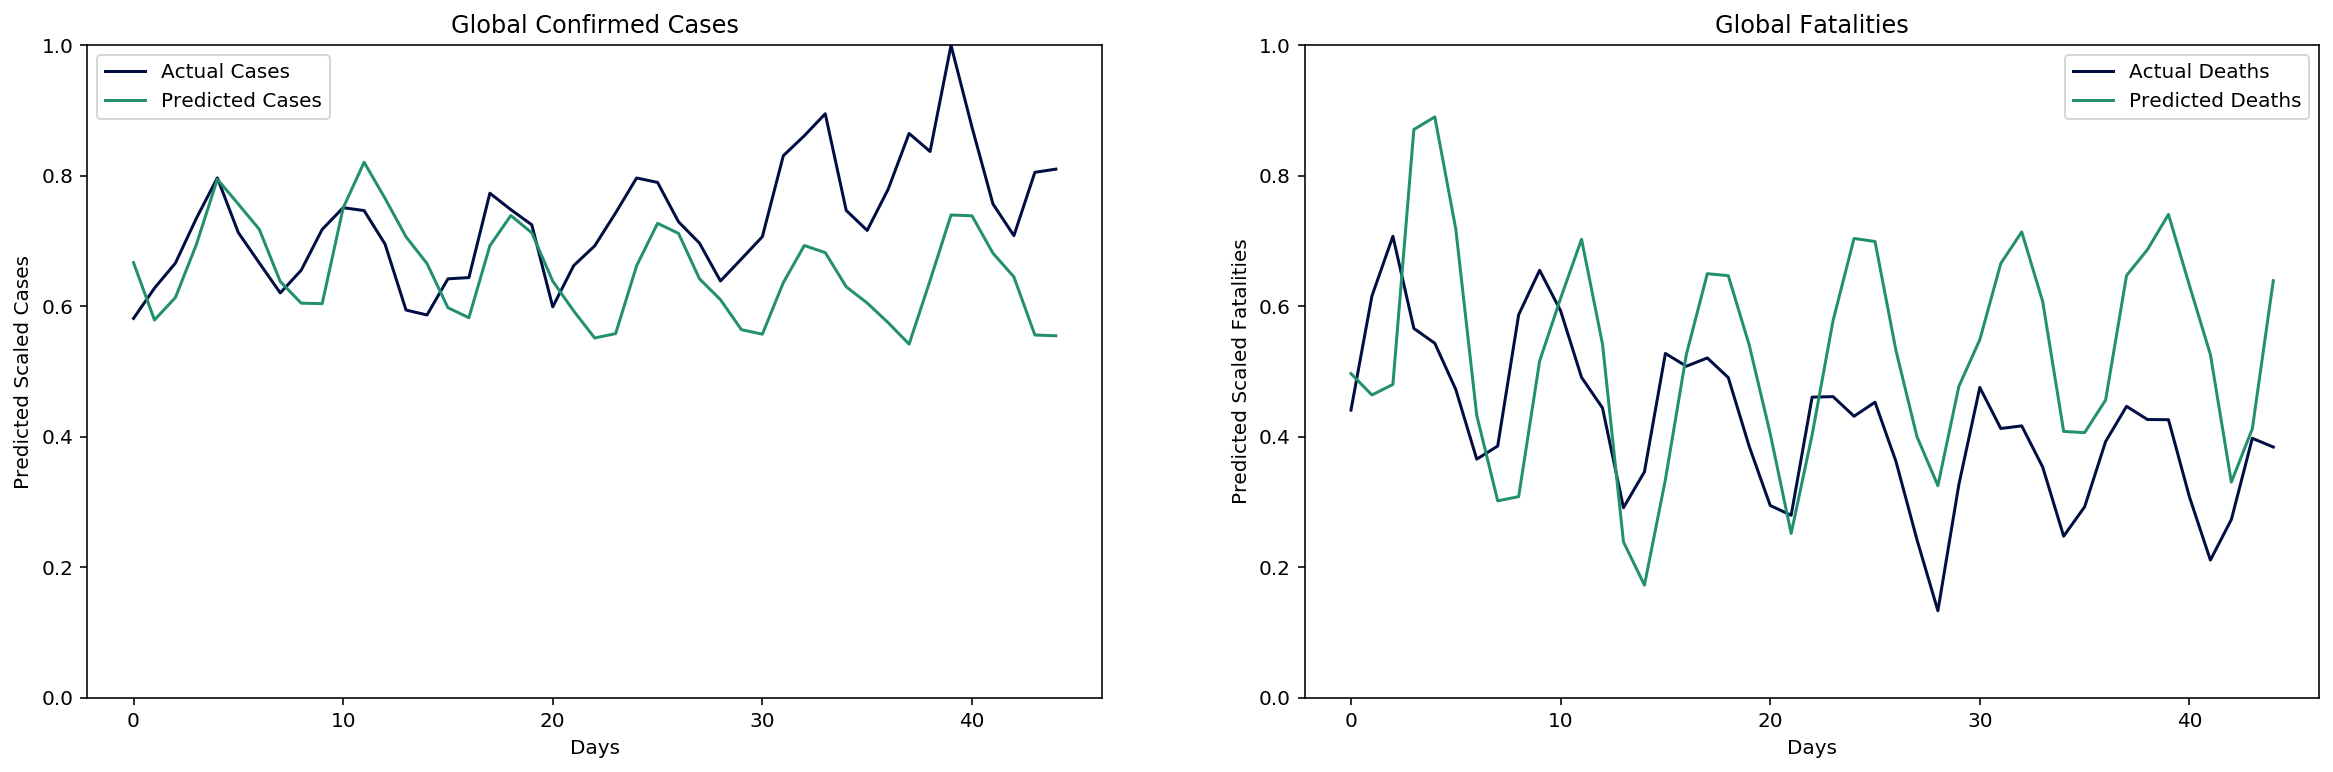

In [215]:
'''Plotting predictions'''
#Actual Values
dset, _ = create_sequences(dataset, seq_length=25)
dset = torch.from_numpy(dset).float()

#Predictions
final = dset[-45:, :]
predictions = cnn(final)

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

# Confirmed Cases
axes[0].plot(dataset[-45:, 0], color='#000E43', label = 'Actual Cases')
axes[0].plot(predictions[:, 0].detach().numpy(), color='#22906F', label='Predicted Cases')
axes[0].set_ylim((0, 1))
axes[0].set_title(f'Global Confirmed Cases')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Predicted Scaled Cases')
axes[0].legend()

# Fatalities
axes[1].plot(dataset[-45:, 1], color='#000E43', label = 'Actual Deaths')
axes[1].plot(predictions[:, 1].detach().numpy(), color='#22906F', label='Predicted Deaths')
axes[1].set_ylim((0, 1))
axes[1].set_title(f'Global Fatalities')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Predicted Scaled Fatalities')
axes[1].legend()

<br>

**Gated Recurrent Unit**

In [275]:
class GRU(nn.Module):
    '''GRU model'''
    def __init__(self, n_input, n_hidden, n_output, seq_len, n_layers=2):
        super().__init__()
        #pdb.set_trace()
        self.n_hidden   = n_hidden
        self.seq_len    = seq_len
        self.n_layers   = n_layers
        
        self.gru = nn.GRU(n_input, n_hidden, n_layers, dropout=0.01)
        self.fc  = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        #pdb.set_trace()
        gru_out, self.hidden = self.gru(x.view(len(x), self.seq_len, -1), self.hidden)
        last_time_step = gru_out.reshape(self.seq_len, len(x), self.n_hidden)[-1]
        out    = self.fc(last_time_step)
        return out
    
    def reset_hidden_state(self):
        self.hidden = torch.zeros(self.n_layers, self.seq_len, self.n_hidden)

In [276]:
'''Training model'''
gru = GRU(n_input=2, n_hidden=512, seq_len=25, n_output=2, n_layers=2)
gru, train_loss, test_loss, values_test, values_train = train_model(gru, X_train, y_train, X_test, y_test, epochs=2500)

-------------------------------------------------
|Epoch: 0 | Train Loss: 25.11 | Test Loss: 11.32|
-------------------------------------------------
|Epoch: 50 | Train Loss: 12.49 | Test Loss: 4.57|
-------------------------------------------------
|Epoch: 100 | Train Loss: 12.12 | Test Loss: 3.36|
--------------------------------------------------
|Epoch: 150 | Train Loss: 12.15 | Test Loss: 4.12|
--------------------------------------------------
|Epoch: 200 | Train Loss: 11.94 | Test Loss: 4.19|
--------------------------------------------------
|Epoch: 250 | Train Loss: 11.8 | Test Loss: 22.6|
-------------------------------------------------
|Epoch: 300 | Train Loss: 11.76 | Test Loss: 31.23|
---------------------------------------------------
|Epoch: 350 | Train Loss: 11.8 | Test Loss: 27.92|
--------------------------------------------------
|Epoch: 400 | Train Loss: 11.69 | Test Loss: 25.73|
---------------------------------------------------
|Epoch: 450 | Train Loss: 11.71 | 

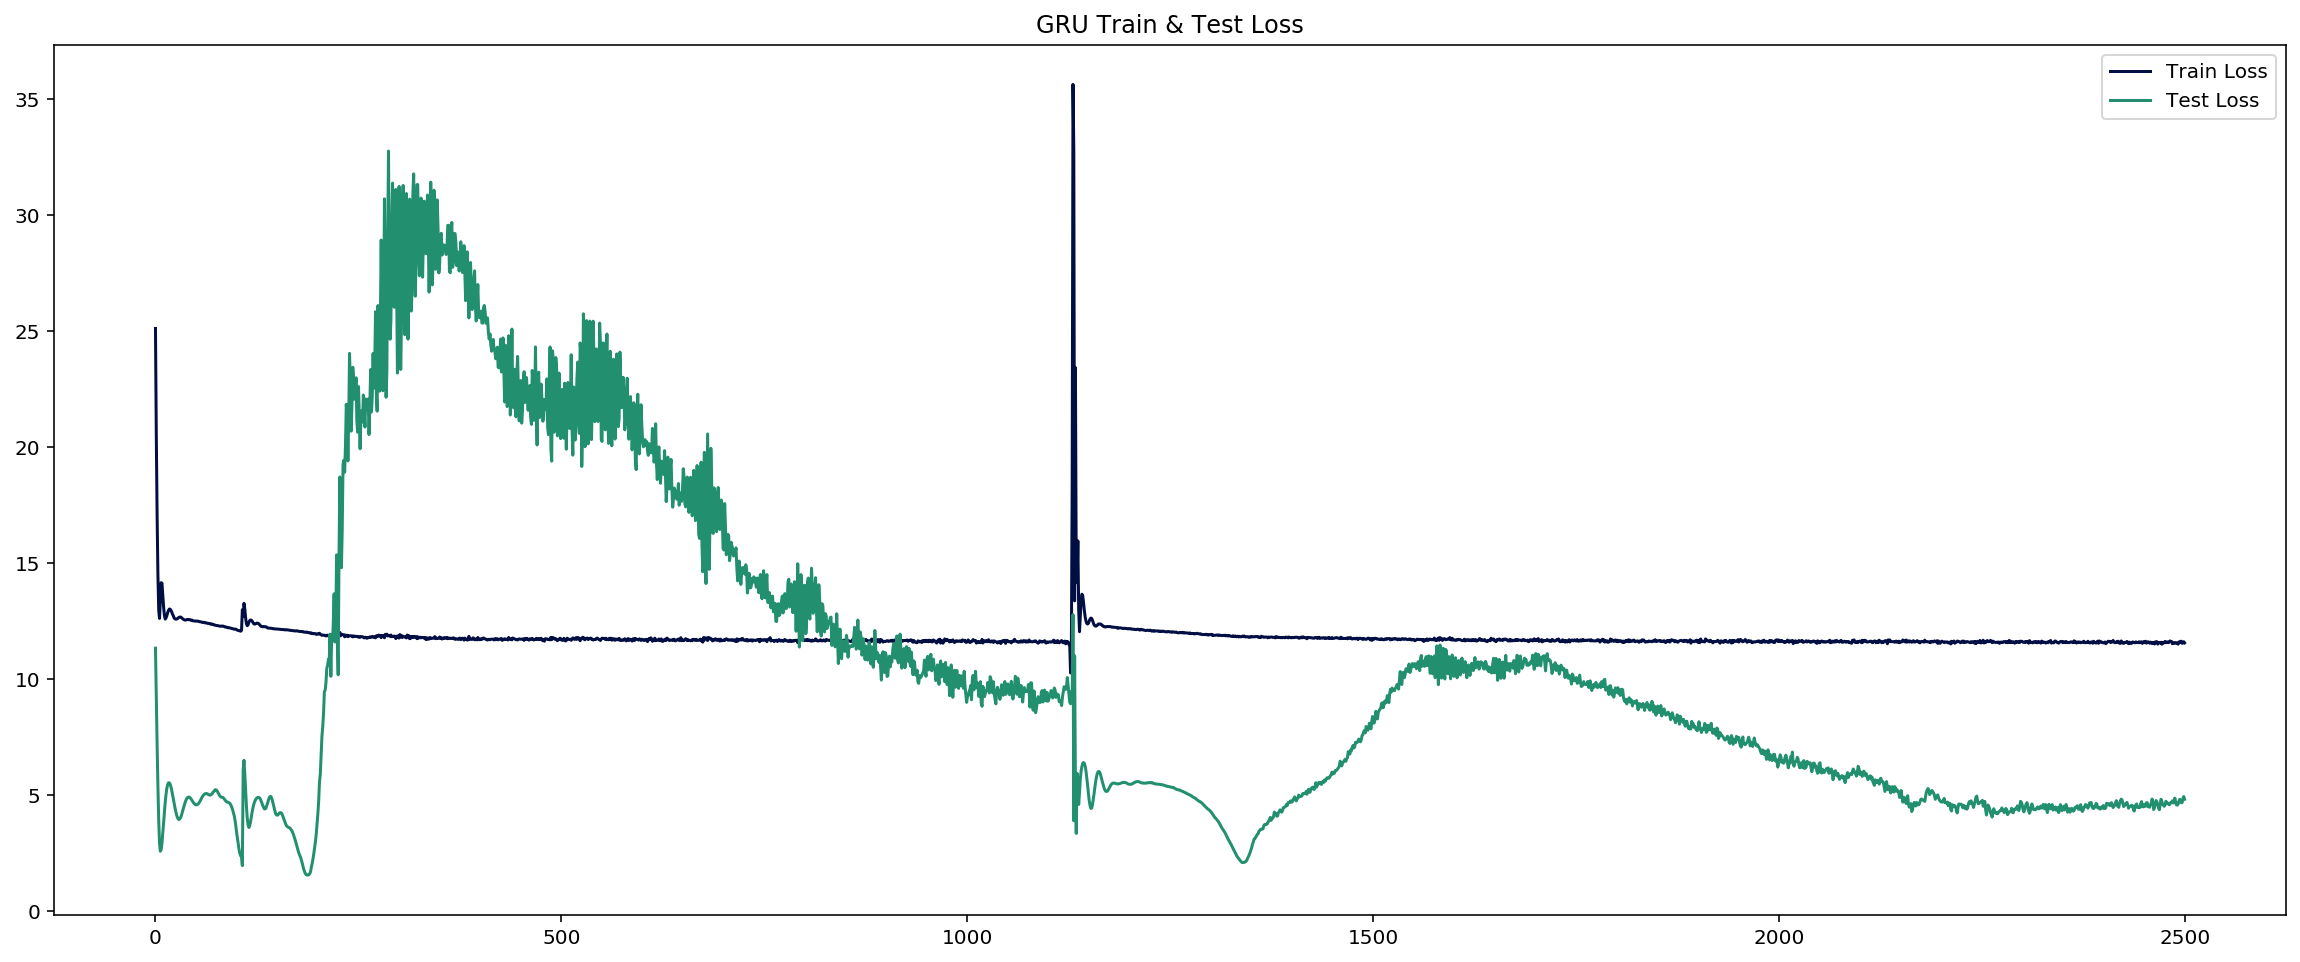

In [277]:
'''Plotting train and test loss'''
plt.figure(figsize=(20, 8))

plt.title('GRU Train & Test Loss')
plt.plot(train_loss, color='#000E43', label = 'Train Loss')
plt.plot(test_loss, color='#22906F', label = 'Test Loss')
plt.legend()

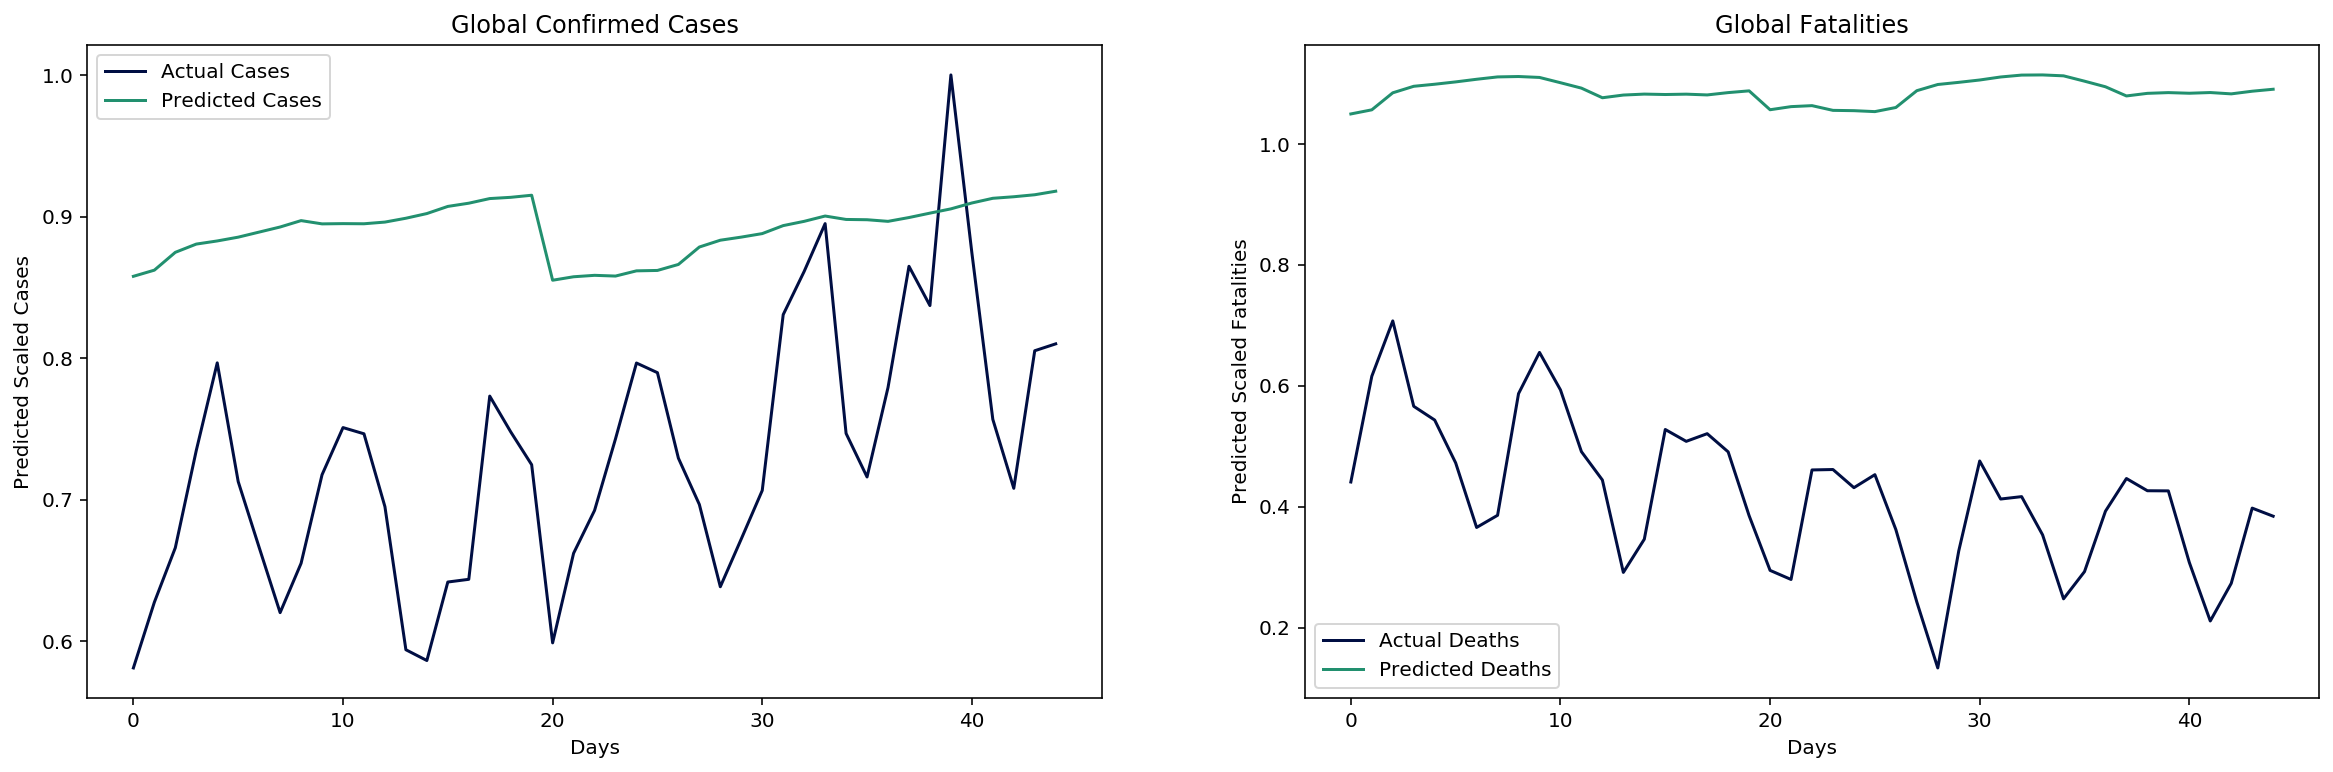

In [278]:
'''Plotting predictions'''
#Actual Values
dset, _ = create_sequences(dataset, seq_length=25)
dset = torch.from_numpy(dset).float()

#Predictions
final = dset[-45:, :]
predictions = gru(final)

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

# Confirmed Cases
axes[0].plot(dataset[-45:, 0], color='#000E43', label = 'Actual Cases')
axes[0].plot(predictions[:, 0].detach().numpy(), color='#22906F', label='Predicted Cases')
#axes[0].set_ylim((0, 1))
axes[0].set_title(f'Global Confirmed Cases')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Predicted Scaled Cases')
axes[0].legend()

# Fatalities
axes[1].plot(dataset[-45:, 1], color='#000E43', label = 'Actual Deaths')
axes[1].plot(predictions[:, 1].detach().numpy(), color='#22906F', label='Predicted Deaths')
#axes[1].set_ylim((0, 1))
axes[1].set_title(f'Global Fatalities')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Predicted Scaled Fatalities')
axes[1].legend()

<br>

#### Regular LSTM

In [244]:
class LSTM(nn.Module):
    '''LSTM model'''
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super().__init__()
        self.n_hidden = n_hidden
        self.seq_len  = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=n_hidden,
                            num_layers=n_layers,
                            dropout=0.01)
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=2)
     
    def reset_hidden_state(self):
        self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                       torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        #pdb.set_trace()
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),
                                          self.hidden)
            
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred  

In [246]:
'''Training model'''
lstm = LSTM(n_features=2, n_hidden=512, seq_len=seq_length, n_layers=2)
lstm, train_loss, test_loss, values_test, values_train = train_model(lstm, X_train, y_train, X_test, y_test, epochs=2500)

-------------------------------------------------
|Epoch: 0 | Train Loss: 26.36 | Test Loss: 13.53|
-------------------------------------------------
|Epoch: 50 | Train Loss: 12.58 | Test Loss: 4.04|
-------------------------------------------------
|Epoch: 100 | Train Loss: 12.08 | Test Loss: 11.55|
---------------------------------------------------
|Epoch: 150 | Train Loss: 11.85 | Test Loss: 22.97|
---------------------------------------------------
|Epoch: 200 | Train Loss: 11.88 | Test Loss: 22.97|
---------------------------------------------------
|Epoch: 250 | Train Loss: 11.79 | Test Loss: 29.03|
---------------------------------------------------
|Epoch: 300 | Train Loss: 11.79 | Test Loss: 27.65|
---------------------------------------------------
|Epoch: 350 | Train Loss: 11.76 | Test Loss: 11.85|
---------------------------------------------------
|Epoch: 400 | Train Loss: 11.72 | Test Loss: 6.31|
--------------------------------------------------
|Epoch: 450 | Train Loss

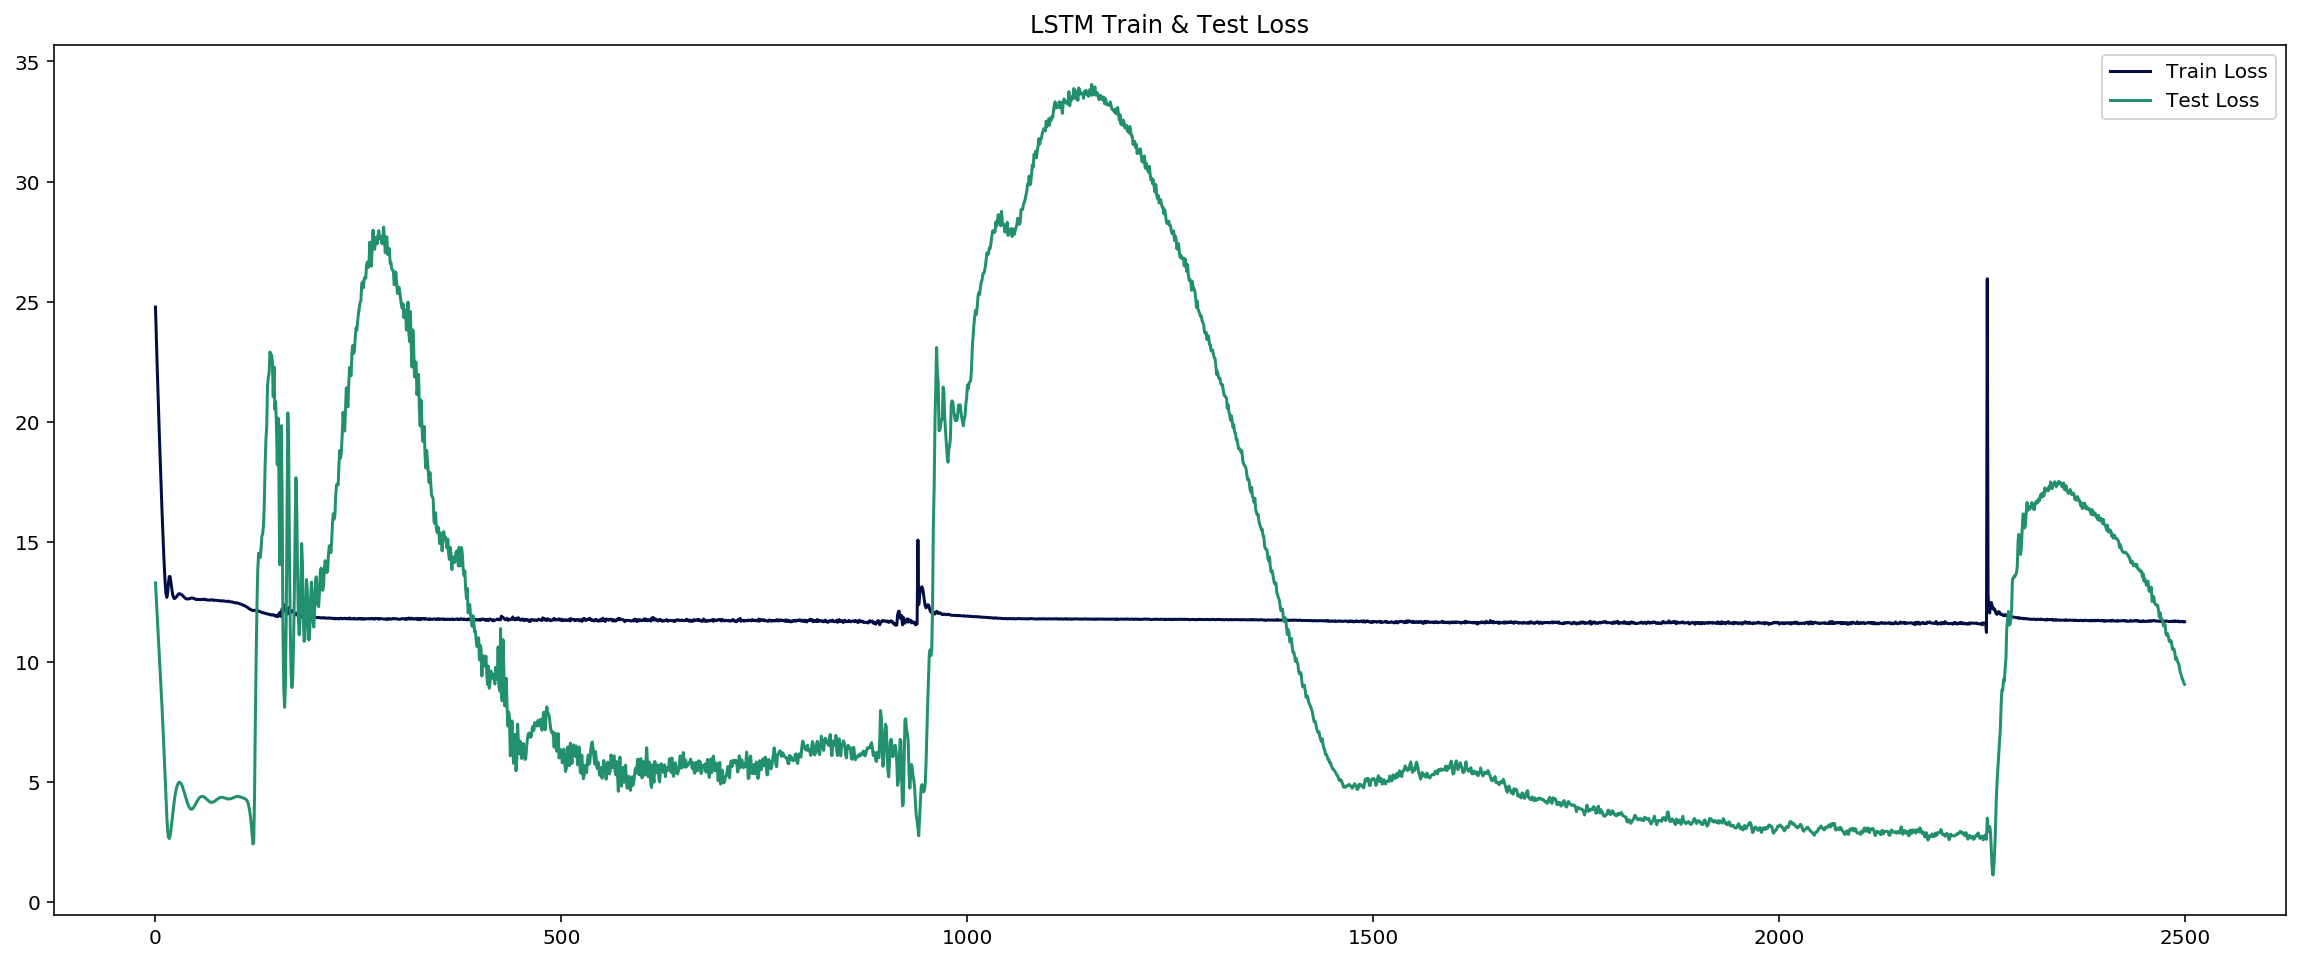

In [239]:
'''Plotting train and test loss'''
plt.figure(figsize=(20, 8))

plt.title('LSTM Train & Test Loss')
plt.plot(train_loss, color='#000E43', label = 'Train Loss')
plt.plot(test_loss, color='#22906F', label = 'Test Loss')
plt.legend()

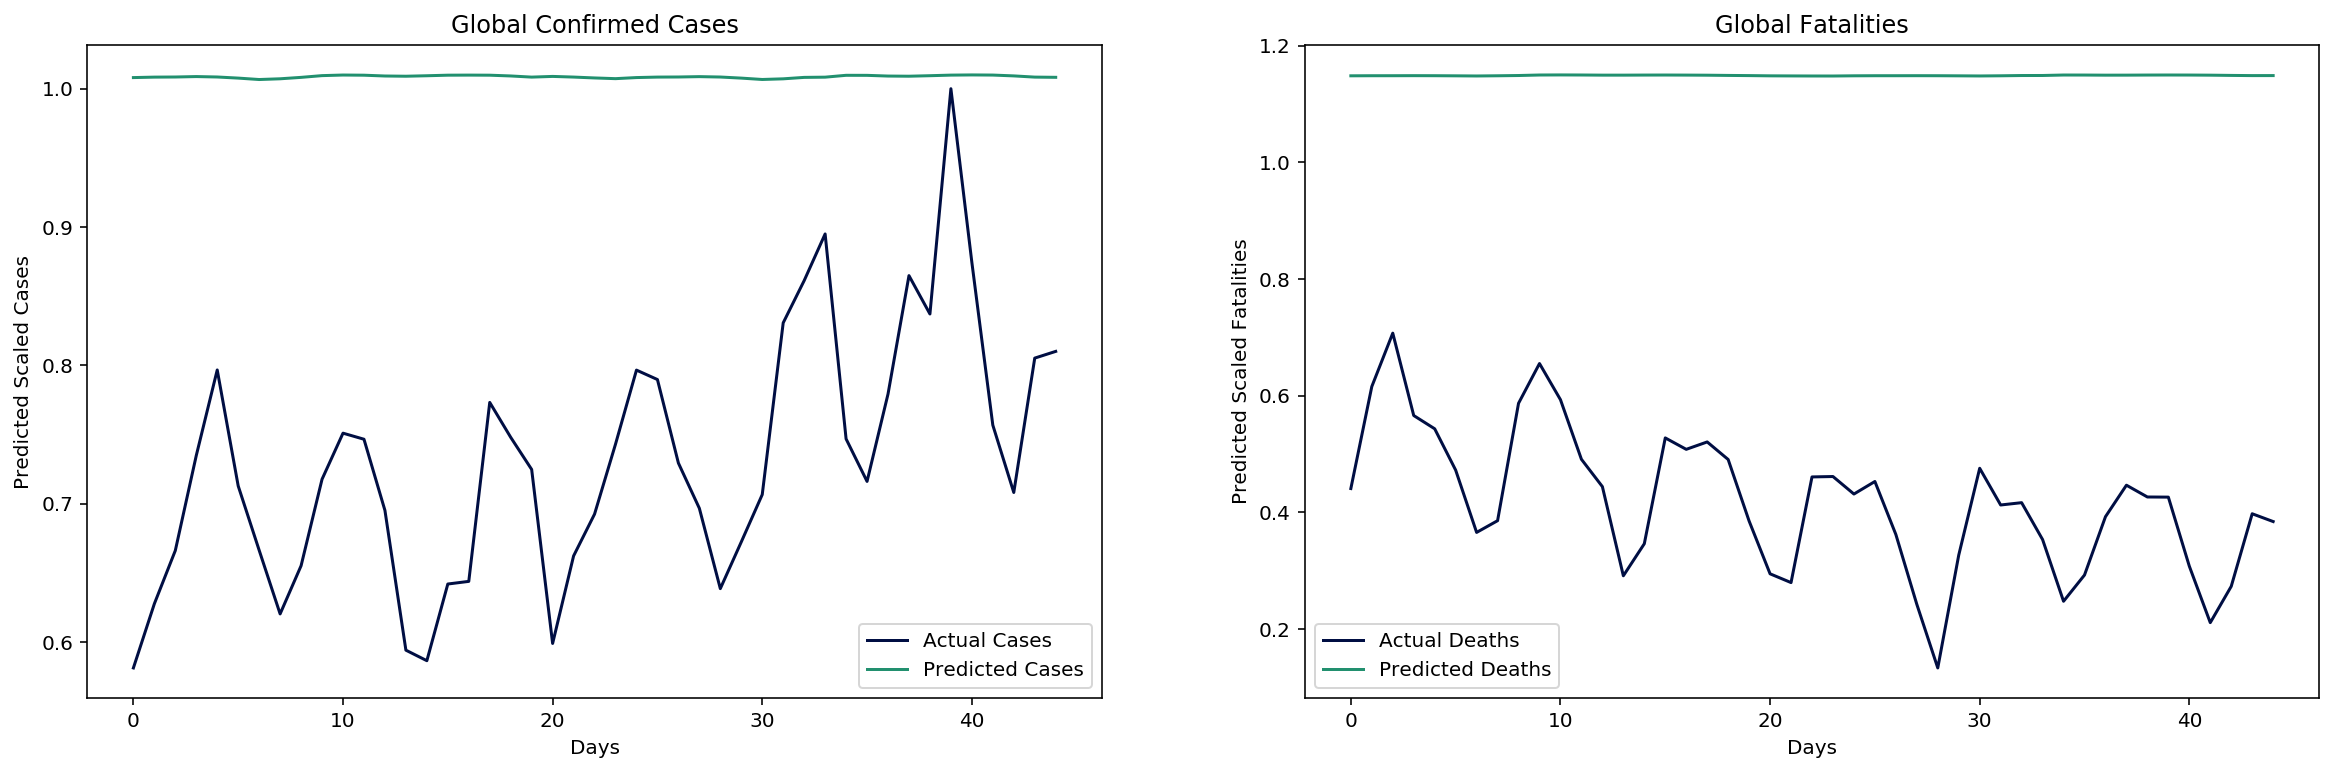

In [243]:
'''Plotting predictions'''
#Actual Values
dset, _ = create_sequences(dataset, seq_length=25)
dset = torch.from_numpy(dset).float()

#Predictions
final = dset[-45:, :]
predictions = lstm(final)

fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

# Confirmed Cases
axes[0].plot(dataset[-45:, 0], color='#000E43', label = 'Actual Cases')
axes[0].plot(predictions[:, 0].detach().numpy(), color='#22906F', label='Predicted Cases')
#axes[0].set_ylim((0, 1))
axes[0].set_title(f'Global Confirmed Cases')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Predicted Scaled Cases')
axes[0].legend()

# Fatalities
axes[1].plot(dataset[-45:, 1], color='#000E43', label = 'Actual Deaths')
axes[1].plot(predictions[:, 1].detach().numpy(), color='#22906F', label='Predicted Deaths')
#axes[1].set_ylim((0, 1))
axes[1].set_title(f'Global Fatalities')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Predicted Scaled Fatalities')
axes[1].legend()

<br>

**Plotting Predictions**

In [187]:
time_start  = [None for i in range(len(y_train)-1)]

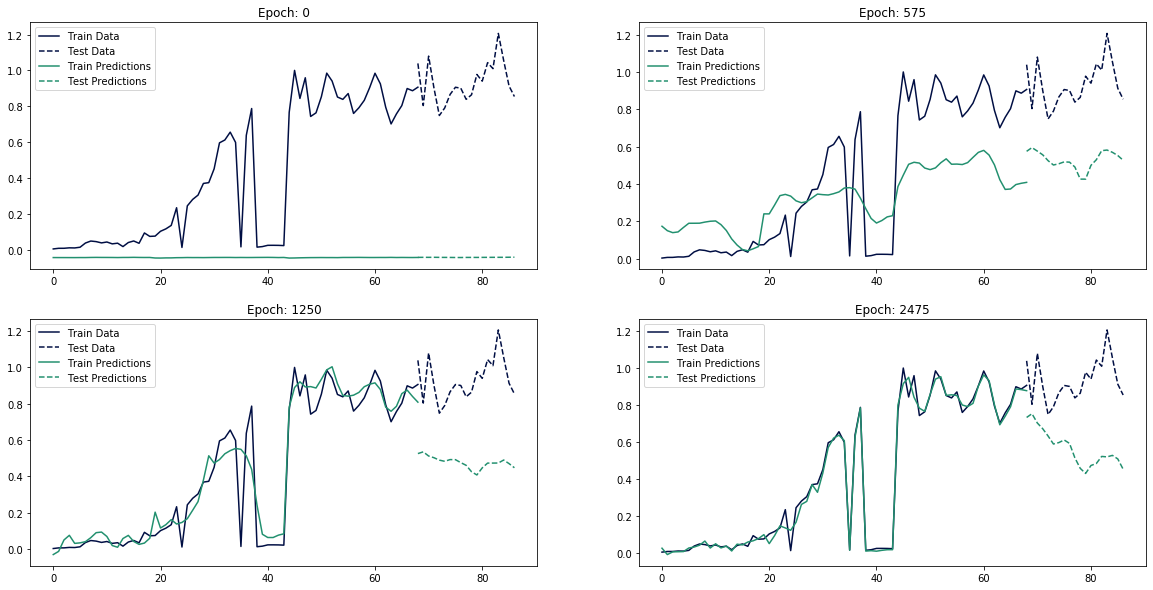

In [255]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))

position = [0, 575, 1250, 2475]
n = 0

for i in range(2):
    for j in range(2):
        axes[i, j].set_title(f'Epoch: {position[n]}')
        axes[i, j].plot(y_train[:, 1], color='#000E43', label = 'Train Data')
        axes[i, j].plot(time_start + list(y_test[:, 1]), color='#000E43', linestyle = 'dashed', label = 'Test Data')
        axes[i, j].plot(values_train[position[n]][:, 1], color='#22906F', label = 'Train Predictions')
        axes[i, j].plot(time_start + list(values_test[position[n]][:, 1]), color='#22906F', linestyle = 'dashed', label = 'Test Predictions')
        axes[i, j].legend()
        n += 1

<br>

**Plotting Results**

(0, 125)

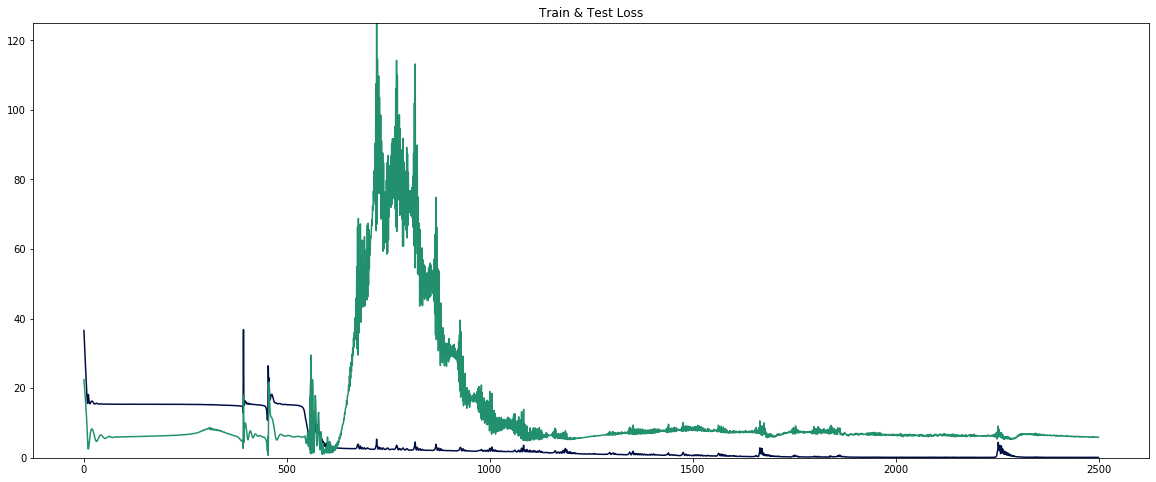

In [176]:
plt.figure(figsize=(20, 8))

plt.title('Train & Test Loss')
plt.plot(train_hist, color='#000E43', label = 'Confirmed Cases')
plt.plot(test_hist, color='#22906F', label = 'Fatalities')
plt.ylim((0, 125))

<br>

**Saving Last Model**

In [201]:
PATH = os.path.join(os.getcwd(), 'Final Project', 'Models', 'LSTM_Full_1')
torch.save(LSTMCoNet, PATH)